In [129]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [130]:
## Download the dataset from kaggle
dataset_dir = "E:\AICTE\Garbage classification\Garbage classification"


In [131]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

In [132]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.25,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 1896 files for training.


In [133]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.25,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 631 files for validation.


In [134]:
val_classes = test_ds.class_names
val_classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [135]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [136]:
val_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

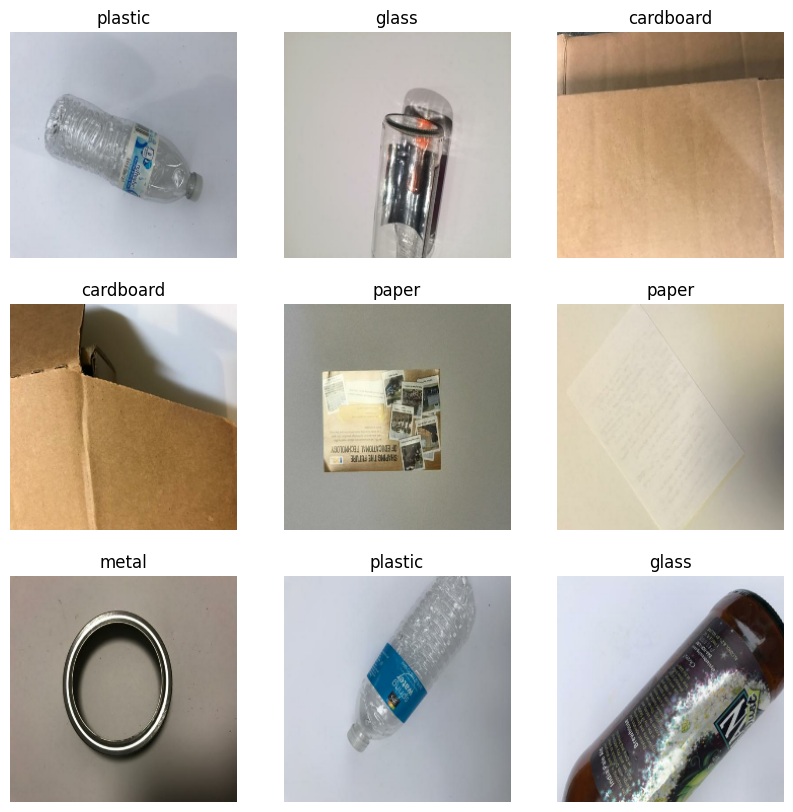

In [137]:
plt.figure(figsize=(10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(val_classes[labels[i]])
        plt.axis('off')

In [138]:
### Checkong imbalance

import collections

class_counts = collections.Counter()
for image, labels in train_ds.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution in training set: ")
for i, count in class_counts.items():
    print(f"{val_classes[i]}: {count}")

Class Distribution in training set: 
plastic: 369
metal: 316
paper: 444
glass: 372
trash: 94
cardboard: 301


In [139]:
## Class weights

from sklearn.utils import class_weight

all_labels = []

for _,labels in train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

class_weights = class_weight.compute_class_weight(
    class_weight= 'balanced',
    classes = np.unique(all_labels),
    y = all_labels,
)

class_weights = {i:w for i,w in enumerate(class_weights)}
print("Computed class weights:")
print(class_weights)

Computed class weights:
{0: 1.0498338870431894, 1: 0.8494623655913979, 2: 1.0, 3: 0.7117117117117117, 4: 0.8563685636856369, 5: 3.3617021276595747}


In [140]:
## Data Augmentation

data_augumentation = Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def preprocess_train(image, label):
    image = preprocess_input(image)  
    return image, label

def preprocess_val(image, label):
    image = preprocess_input(image)
    return image, label


In [142]:
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


In [143]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, models

IMAGE_SHAPE = (224, 224, 3)
NUM_CLASSES = len(val_classes)

# Load EfficientNetV2B2 base model
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=IMAGE_SHAPE,
    weights='imagenet'
)
base_model.trainable = False  # freeze base model

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(224, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile it
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 7, 7, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_19  (None, 1408)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_38 (Dense)            (None, 224)               315616    
                                                                 
 dropout_19 (Dropout)        (None, 224)               0         
                                                                 
 dense_39 (Dense)            (None, 6)                 1350      
                                                                 
Total params: 9,086,340
Trainable params: 316,966
Non

In [144]:
early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [145]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=15,
    callbacks = [early],
)

Epoch 1/15
60/60 [==============================] - 15s 168ms/step - loss: 0.6233 - accuracy: 0.7832 - val_loss: 0.3929 - val_accuracy: 0.8605
Epoch 2/15
60/60 [==============================] - 8s 126ms/step - loss: 0.2944 - accuracy: 0.8961 - val_loss: 0.3949 - val_accuracy: 0.8558
Epoch 3/15
60/60 [==============================] - 8s 128ms/step - loss: 0.2211 - accuracy: 0.9277 - val_loss: 0.3453 - val_accuracy: 0.8875
Epoch 4/15
60/60 [==============================] - 8s 129ms/step - loss: 0.1658 - accuracy: 0.9483 - val_loss: 0.3203 - val_accuracy: 0.8922
Epoch 5/15
60/60 [==============================] - 9s 143ms/step - loss: 0.1435 - accuracy: 0.9531 - val_loss: 0.3090 - val_accuracy: 0.8954
Epoch 6/15
60/60 [==============================] - 9s 142ms/step - loss: 0.1164 - accuracy: 0.9662 - val_loss: 0.3190 - val_accuracy: 0.9033
Epoch 7/15
60/60 [==============================] - 9s 144ms/step - loss: 0.0900 - accuracy: 0.9720 - val_loss: 0.3475 - val_accuracy: 0.9002
Epoch

In [146]:
model.evaluate(val_ds)

20/20 [==============================] - 2s 93ms/step - loss: 0.2887 - accuracy: 0.9017


[0.28866833448410034, 0.9017432928085327]

1/1 [==============================] - 0s 23ms/step


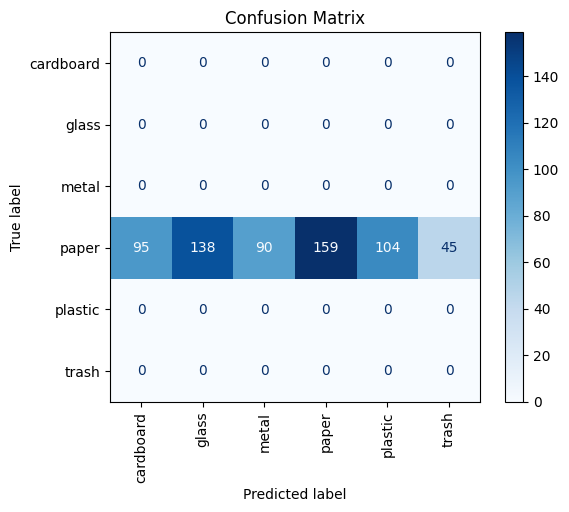

In [147]:
## Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labl in val_ds.unbatch():
    preds = model.predict(tf.expand_dims(images, 0))
    y_true.append(int(labels.numpy()))
    y_pred.append(np.argmax(preds))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_classes)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [148]:
## HyperParameter Tuning

from tensorflow.keras.applications import (
    EfficientNetB0,
    EfficientNetV2B2,
    MobileNetV2,
    ResNet50,
    Xception
)

In [149]:
def get_base_model(name, input_shape=(224, 224, 3)):
    if name == 'EfficientNetB0':
        return EfficientNetB0(include_top=False,input_shape=input_shape,weights='imagenet')
    elif name == 'EfficientNetV2B2':
        return EfficientNetV2B2(include_top=False, input_shape=input_shape, weights='imagenet')
    elif name == 'MobileNetV2':
        return MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    elif name == 'ResNet50':
        return ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    elif name == 'Xception':
        return Xception(include_top=False, input_shape=input_shape, weights='imagenet')
    else:
        raise ValueError("Invalid Model")

In [150]:
def build_transfer_model(base_model, num_classes):
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, 'softmax')
        
    ])
    model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    return model

In [151]:
model_names = ['EfficientNetB0', 'EfficientNetV2B2', 'MobileNetV2', 'ResNet50', 'Xception']
results = {}

for name in model_names:
    print(f"\nTraining With {name}")
    base = get_base_model(name)
    model = build_transfer_model(base, num_classes=len(val_classes))

    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = 5,
        class_weight = class_weights,
        callbacks = [early]

    )

    val_loss , val_accuracy = model.evaluate(val_ds)
    results[name] = val_accuracy



Training With EfficientNetB0
Epoch 1/5
60/60 [==============================] - 10s 111ms/step - loss: 0.8325 - accuracy: 0.7210 - val_loss: 0.4322 - val_accuracy: 0.8463
Epoch 2/5
60/60 [==============================] - 6s 95ms/step - loss: 0.3627 - accuracy: 0.8782 - val_loss: 0.3649 - val_accuracy: 0.8637
Epoch 3/5
60/60 [==============================] - 6s 95ms/step - loss: 0.2486 - accuracy: 0.9188 - val_loss: 0.3293 - val_accuracy: 0.8796
Epoch 4/5
60/60 [==============================] - 6s 96ms/step - loss: 0.1790 - accuracy: 0.9436 - val_loss: 0.3101 - val_accuracy: 0.8843
Epoch 5/5
20/20 [==============================] - 1s 72ms/step - loss: 0.3172 - accuracy: 0.8827

Training With EfficientNetV2B2
Epoch 1/5
60/60 [==============================] - 14s 152ms/step - loss: 0.7618 - accuracy: 0.7400 - val_loss: 0.4922 - val_accuracy: 0.8193
Epoch 2/5
60/60 [==============================] - 8s 129ms/step - loss: 0.3888 - accuracy: 0.8608 - val_loss: 0.4162 - val_accuracy: 0.

In [152]:
results

{'EfficientNetB0': 0.8827258348464966,
 'EfficientNetV2B2': 0.8874801993370056,
 'MobileNetV2': 0.670364499092102,
 'ResNet50': 0.830427885055542,
 'Xception': 0.3423137962818146}

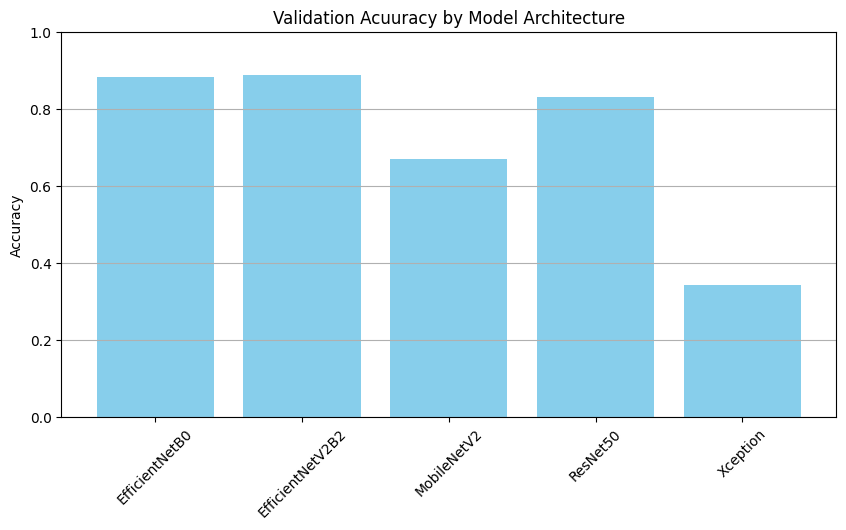

In [153]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10,5)),
plt.bar(model_names, accuracies, color='skyblue')
plt.title("Validation Acuuracy by Model Architecture")
plt.ylabel("Accuracy") 
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [154]:
## Selecting EfficientNetV2B2 due to lighter model, faster and Better Accuracy
from tensorflow.keras.layers import Rescaling

IMAGE_SHAPE = (224, 224, 3)
NUM_CLASSES = len(val_classes)

# Load EfficientNetV2B2 base model
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=IMAGE_SHAPE,
    weights='imagenet'
)
base_model.trainable = False  # freeze base model

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(224, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile it
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 7, 7, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_25  (None, 1408)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_50 (Dense)            (None, 224)               315616    
                                                                 
 dropout_25 (Dropout)        (None, 224)               0         
                                                                 
 dense_51 (Dense)            (None, 6)                 1350      
                                                                 
Total params: 9,086,340
Trainable params: 316,966
Non

In [155]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    class_weight=class_weights,
    callbacks = [early]
)

Epoch 1/30
60/60 [==============================] - 28s 241ms/step - loss: 0.7194 - accuracy: 0.7537 - val_loss: 0.4865 - val_accuracy: 0.8130
Epoch 2/30
60/60 [==============================] - 11s 174ms/step - loss: 0.3444 - accuracy: 0.8676 - val_loss: 0.3795 - val_accuracy: 0.8558
Epoch 3/30
60/60 [==============================] - 10s 175ms/step - loss: 0.2402 - accuracy: 0.9188 - val_loss: 0.3440 - val_accuracy: 0.8748
Epoch 4/30
60/60 [==============================] - 9s 141ms/step - loss: 0.1882 - accuracy: 0.9362 - val_loss: 0.3437 - val_accuracy: 0.8780
Epoch 5/30
60/60 [==============================] - 8s 137ms/step - loss: 0.1493 - accuracy: 0.9509 - val_loss: 0.3532 - val_accuracy: 0.8748
Epoch 6/30
60/60 [==============================] - 9s 144ms/step - loss: 0.1287 - accuracy: 0.9525 - val_loss: 0.3331 - val_accuracy: 0.8875
Epoch 7/30
60/60 [==============================] - 8s 141ms/step - loss: 0.1138 - accuracy: 0.9583 - val_loss: 0.3216 - val_accuracy: 0.8986
Epo

In [156]:
val_loss, val_accuracy = model.evaluate(val_ds)

20/20 [==============================] - 2s 94ms/step - loss: 0.3051 - accuracy: 0.9065


In [157]:
val_loss, val_accuracy

(0.3051307201385498, 0.906497597694397)

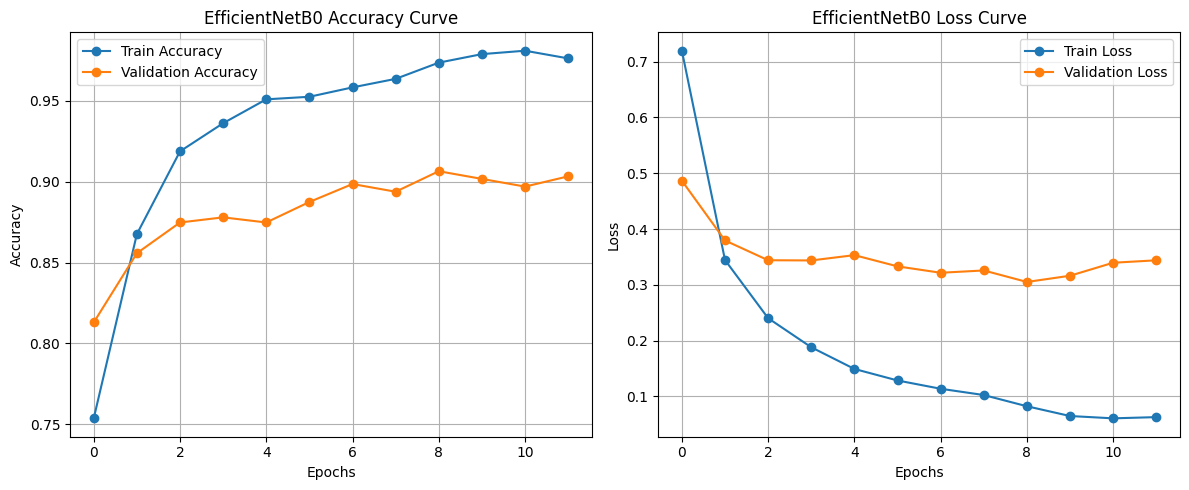

In [158]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('EfficientNetB0 Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('EfficientNetB0 Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step


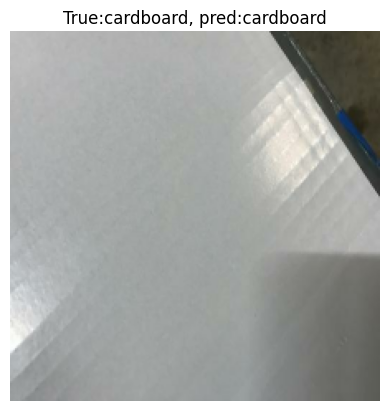

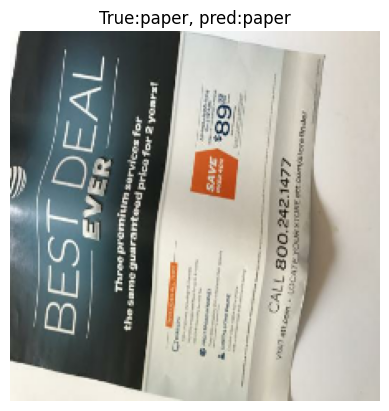

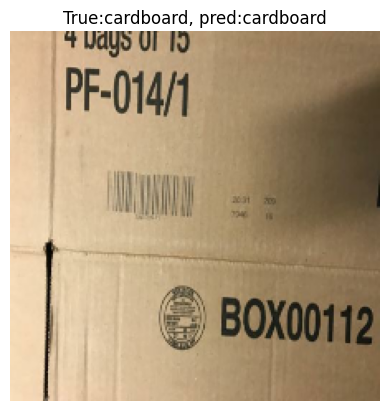

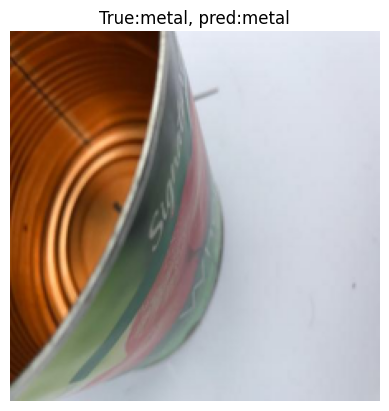

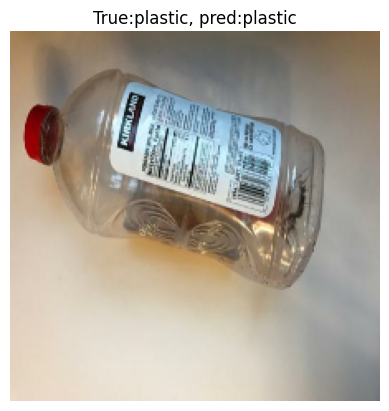

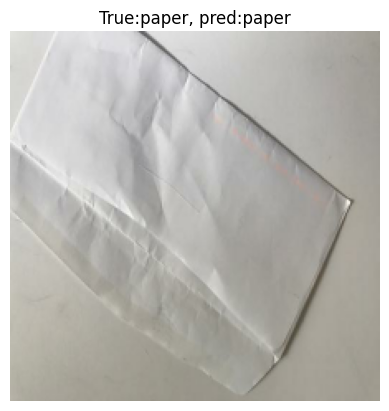

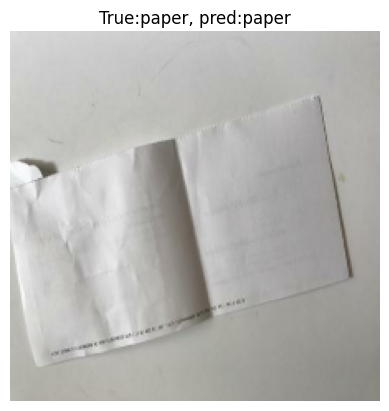

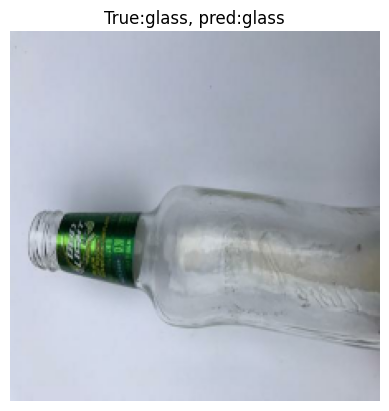

In [159]:
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True:{val_classes[labels[i]]}, pred:{val_classes[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [163]:
model.save("GarbageClassifier.h5", save_format='h5')


In [161]:
model.evaluate(test_ds)

20/20 [==============================] - 2s 104ms/step - loss: 0.3051 - accuracy: 0.9065


[0.305134117603302, 0.906497597694397]

1/1 [==============================] - 0s 35ms/step


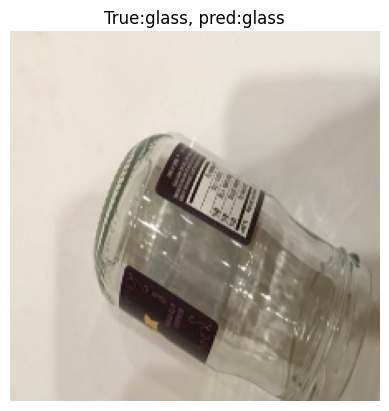

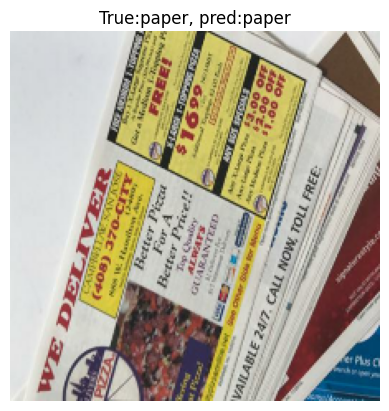

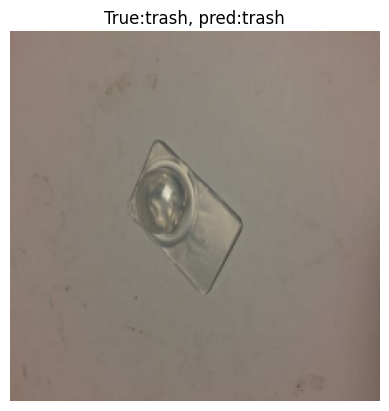

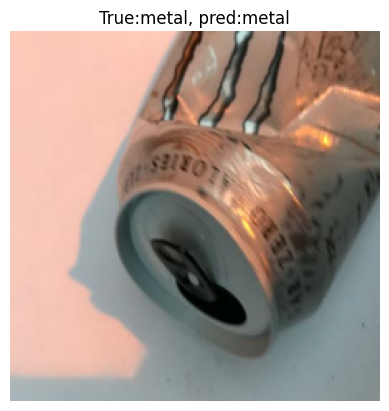

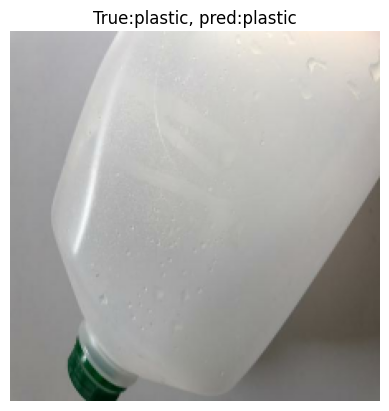

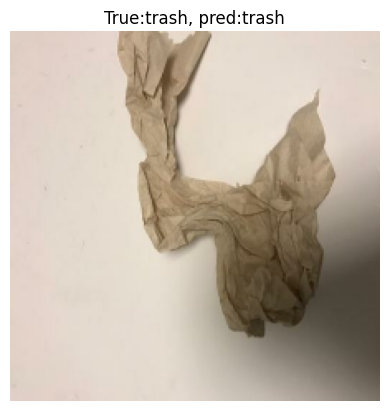

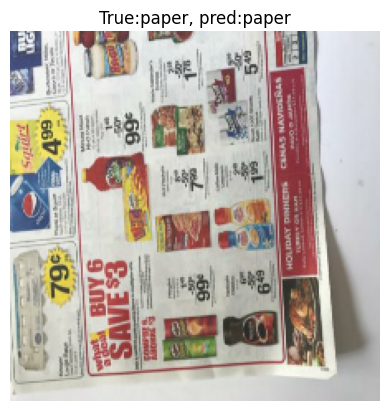

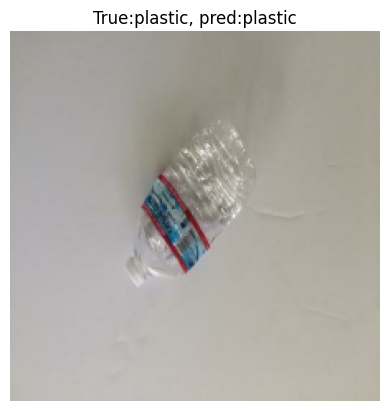

In [162]:
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True:{val_classes[labels[i]]}, pred:{val_classes[pred_labels[i]]}")
        plt.axis("off")
        plt.show()
